## Notebook to cast 405 unique dataset genres to 8 classification genres.


In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)

Read in data and remove any NA cells.


In [2]:
data = pd.read_csv("summarized_scripts.csv")
data = data[~data.summ_scripts_4.isna()]
data = data[~data.genres.isnull()]

Each dataset genre consists of comma-delimited strings, used to define sub-genres. Extract these strings, for downstream consolidation of sub-genres to classification genres.

In [3]:
genres = data[['genres']]

In [4]:
split = pd.DataFrame(genres.genres.value_counts().index)[0].str.split(',',expand=True)

In [5]:
uniques = pd.Series(split.unstack().reset_index(drop=True).unique()).str.strip().unique()

In [6]:
uniques = list(uniques)
uniques = [i for i in uniques if i]
uniques

['Drama',
 'Comedy',
 'Crime',
 'Action',
 'Adventure',
 'Animation',
 'Thriller',
 'Mystery',
 'Horror',
 'Western',
 'Fantasy',
 'Science Fiction',
 'Romance',
 'Music',
 'Family',
 'War',
 'TV Movie']

Cast these strings to broader genres for consolidation.

In [7]:
new_genre = ['Drama', # Drama,
            'Comedy', # Comedy,
            'Action', # Crime,
            'Action', # Action,
            'Action', # Adventure,
            'Other', # Animation,
            'Action', # Thriller,
            'Drama', # Mystery,
            'Horror', # Horror,
            'Action', # Western,
            'Other', # Fantasy,
            '', # Science Fiction,
            '', # Music,
            'Romance', # Romance,
            '', # Family,
            'Action', # War,
            ''] # TV movie

Create a dictionary for old and new genre strings.


In [12]:
genre_dict = dict(zip(uniques, new_genre))

In [13]:
dict_df = pd.DataFrame(genre_dict.items())
dict_df.columns = ['old_name','new_name']
dict_df

,old_name,new_name
0,Drama,Drama
1,Comedy,Comedy
2,Crime,Action
3,Action,Action
4,Adventure,Action
5,Animation,Other
6,Thriller,Action
7,Mystery,Drama
8,Horror,Horror
9,Western,Action


Get dataset genres and split into sub-string. Then collapse genre names by converting those substrings with the genre dicitonary.
Fill NA values with empty strings.

In [31]:
data_genres = pd.Series(genres.genres.value_counts().index).astype(str)
data_genres_split = data_genres.str.split(',',expand=True).astype(str)

columns = list(data_genres_split)
for i in columns:
    data_genres_split[i] = data_genres_split[i].str.strip().map(genre_dict)
    
mask = data_genres_split.applymap(lambda x: x is None)
cols = data_genres_split.columns[(mask).any()]
for col in data_genres_split[cols]:
    data_genres_split.loc[mask[col], col] = ''
data_genres_split = data_genres_split.fillna('')

Create final genre name by collapsing sub-string duplicates and manually assigning primary genres.

In [53]:
new_genres = []
rom_coms = ['Comedy Drama Romance', 'Comedy Romance']

for i in data_genres_split.values.tolist():
    dedup = []
    [dedup.append(x) for x in i if x not in dedup]
    new_name = [x for x in dedup if x]
    new_name.sort()
    final_name = " ".join(new_name)
    if final_name == '':
        casted_name = 'Other'
    elif 'Horror' in final_name:
        casted_name = 'Action Drama'
    elif 'Romance' in final_name:
        casted_name = 'Romance'
    elif 'Action Comedy' in final_name:
        casted_name = 'Action Comedy'
    elif final_name == 'Other':
        casted_name = 'Other'
    elif 'Other' in final_name:
        casted_name = final_name.replace('Other','').strip()
    else:
        casted_name = final_name
    new_genres.append(casted_name)

Create dictionary to map classification genres to dataset genres.

In [74]:
final_genre_dict = dict(zip(data_genres, new_genres))

Map final dictionary to original dataset.


In [75]:
original_data = pd.read_csv("moviedataset.csv")

In [76]:
original_data = original_data[~original_data.Scripts.isna()]
original_data = original_data[~original_data.genres.isna()]

In [77]:
original_data['new_genres'] = original_data.genres.map(final_genre_dict)

In [78]:
original_data.new_genres.value_counts()

Action Drama     879
Drama            511
Action           497
Comedy           482
Action Comedy    435
Comedy Drama     410
Romance           85
Other             33
Name: new_genres, dtype: int64

In [ ]:
final_df = original_data[['movie title','genres','Scripts','new_genres']]
final_df[final_df.new_genres.isna()] = 'Comedy'
final_df = final_df[final_df.new_genres != 'Other']

In [136]:
final_df

,movie title,genres,Scripts,new_genres
0,The Hours,Drama,"Dearest, I feel certain that I am going mad ag...",Drama
1,A.I. Artificial Intelligence,"Adventure, Drama, Science Fiction",Al That was when the icecaps had melted becaus...,Action Drama
2,The Bridges of Madison County,"Drama, Romance","- MICHAEL: Hi, sis. - CAROLYN: Hey. - CAROLYN:...",Drama
3,The Devil Wears Prada,"Comedy, Drama, Romance","Good luck. Hi. Uh, I have an appointment with ...",Comedy Drama
4,The House of the Spirits,"Drama, Romance",THE HOUSE OF THE SPIRITS. It’s good to be back...,Drama
...,...,...,...,...
3909,Daddy's Home 2,Comedy,"Subtitles by <font color=""#ff0000"">explosivesk...",Comedy
3910,Curious George,"Adventure, Animation, Comedy, Family","Play one of the best new FPS shooters, search ...",Action Comedy
3911,The House,Comedy,"♪ Open up the champagne, pop! ♪ It's my house,...",Comedy
3913,Drowning Mona,"Comedy, Crime, Mystery","Shit. I see. Is that right? Well, have you eve...",Action Comedy


In [137]:
#working file
final_df.to_csv("cleaned_moviedataset.csv",index=False)

Plotting

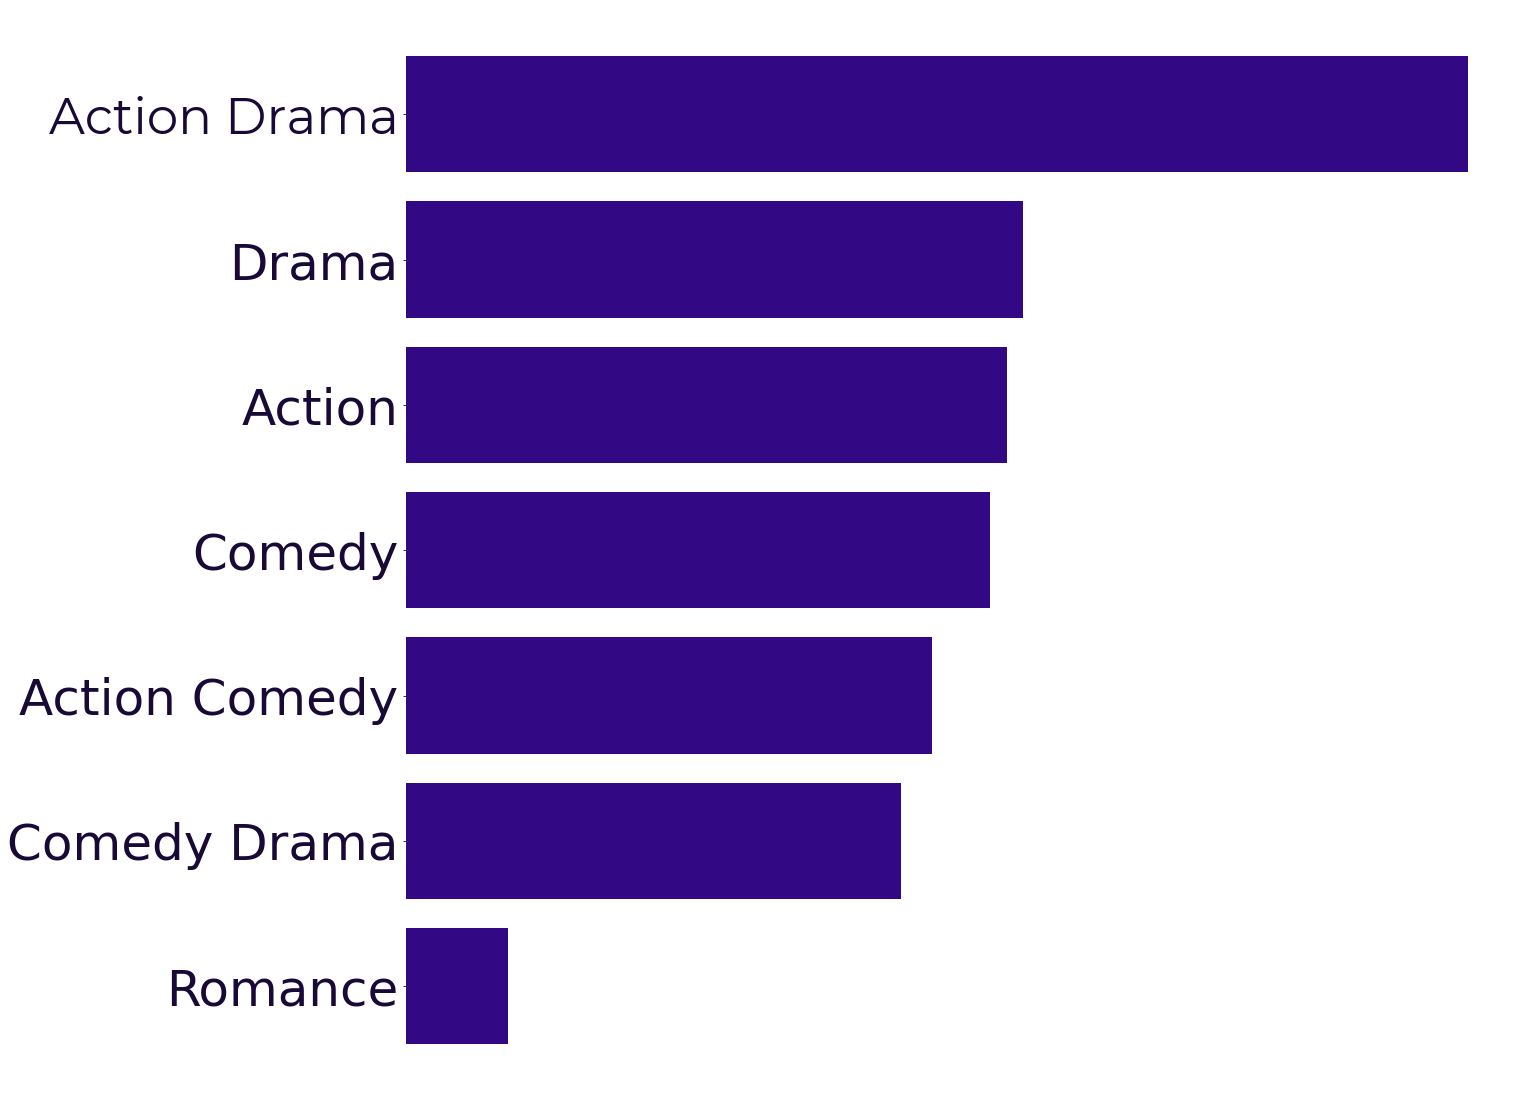

In [19]:
from matplotlib import font_manager as fm
import matplotlib.pyplot as plt
import numpy as np 

font = 'Montserrat-Regular.ttf'
data = pd.read_csv("cleaned_moviedataset.csv")

genre_dist = pd.DataFrame(data.new_genres.value_counts())
genre_dist

prop = fm.FontProperties(fname=font, size=35)
plt.figure(figsize=[20,20])

ind = np.arange(len(genre_dist))[::-1]
labels = ['Action Drama',
          'Drama',
          'Action',
          'Comedy',
          'Action Comedy',
          'Comedy Drama',
          'Romance']
plt.tight_layout()

plt.barh(genre_dist.index[::-1],genre_dist.new_genres[::-1],color='#330884')
plt.xticks([]);
plt.yticks(ind,labels=labels, fontproperties=prop, size=50, color='#190937')

plt.box(False)
plt.savefig('fig_genre_dist.png',transparent=True,dpi=250, bbox_inches = "tight")